In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('white')

path = Path('data', 'time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'
seq_len = 24
n_seq = 6

Using GPU


In [4]:
# Load Data
experiment = 0

def get_real_data():
    df = pd.read_hdf(hdf_store, 'data/real').sort_index()

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])
    return data

real_data = get_real_data()

In [5]:
real_data[:3]

[array([[4.87439448e-02, 2.20375560e-02, 0.00000000e+00, 6.93856237e-01,
         8.21105554e-02, 1.33289246e-02],
        [4.74516541e-02, 2.22460261e-02, 5.11114966e-05, 6.83225480e-01,
         8.05108954e-02, 1.08605983e-02],
        [4.68054929e-02, 2.21209476e-02, 9.51507992e-05, 6.77909854e-01,
         8.08307945e-02, 1.11426783e-02],
        [4.69777980e-02, 2.20584054e-02, 9.90832499e-05, 6.84916592e-01,
         8.17106767e-02, 1.19889953e-02],
        [4.58147799e-02, 2.18916340e-02, 4.68671440e-04, 6.79601263e-01,
         8.04709352e-02, 1.27647133e-02],
        [4.62885777e-02, 2.21626405e-02, 4.45869443e-04, 6.77426344e-01,
         7.99509914e-02, 1.17774033e-02],
        [4.59870743e-02, 2.20167125e-02, 9.98655952e-05, 6.65103874e-01,
         7.84714228e-02, 1.18479254e-02],
        [4.81839440e-02, 2.21209476e-02, 1.70644526e-04, 6.71869420e-01,
         7.88313677e-02, 1.38225711e-02],
        [4.83131848e-02, 2.10577208e-02, 5.11923216e-04, 6.60996353e-01,
       

In [6]:
n = len(real_data)
n, np.asarray(real_data).shape

(4634, (4634, 24, 6))

In [7]:
synthetic_data = np.load(path / f'experiment_{experiment:02d}' / 'generated_data.npy') # reload synthetic data
synthetic_data.shape

(4608, 24, 6)

In [8]:
synthetic_data.data

In [9]:
synthetic_data.tolist()

[[[0.7621334791183472,
   0.4292222857475281,
   0.3525233566761017,
   0.24686112999916077,
   0.6580295562744141,
   0.34356969594955444],
  [0.6079561710357666,
   0.4437429904937744,
   0.33326855301856995,
   0.1870473176240921,
   0.633182942867279,
   0.37264367938041687],
  [0.6098018288612366,
   0.43503618240356445,
   0.36090317368507385,
   0.1497783660888672,
   0.5672624707221985,
   0.332811564207077],
  [0.5703775882720947,
   0.44113799929618835,
   0.327793151140213,
   0.15496358275413513,
   0.5827340483665466,
   0.3288686275482178],
  [0.5715625286102295,
   0.4437817335128784,
   0.3376457691192627,
   0.16041044890880585,
   0.5879368782043457,
   0.32413485646247864],
  [0.5655956268310547,
   0.45233720541000366,
   0.34696245193481445,
   0.16502362489700317,
   0.5864324569702148,
   0.33014190196990967],
  [0.5599360466003418,
   0.4568300247192383,
   0.35045626759529114,
   0.16775688529014587,
   0.584174394607544,
   0.3321121633052826],
  [0.5587041974

In [10]:
real_data = real_data[:synthetic_data.shape[0]] # ensure same number of sequences

In [11]:
np.random.permutation(len(real_data))[:250]

array([2637,  664,  445,  715,  786, 3490, 1662,  995, 4400,  505, 3723,
       2553, 1070, 3959, 2859, 3438,  851,  448, 4093, 2349, 1717, 3278,
       3809, 2373, 2871, 3387,  687, 4508, 1645, 4051,  862, 4110, 2284,
        561, 2084, 2796,  199, 2475, 3952,  571,  511,  808,  601,  978,
       2737, 1126, 2507, 1844, 3411,  588, 2418,  977, 3944,   52, 3513,
       1690, 3984, 3546, 2267,  671, 2490, 4228, 2788, 2658, 4211, 2998,
       1443, 4385, 4015, 1581,  554, 2678, 2571, 2928, 2823, 2685, 2495,
       2094, 2146, 3822, 3159, 1825, 2622, 2625,  787, 1413, 1648,    0,
       2423, 1168, 4036,  340, 2290, 3607,  876, 1664,  321,  694, 1724,
       3166,  460, 3619,  303, 1317, 3245, 2209, 4356, 3742, 1630,   38,
       3120, 1513,  697, 2346, 2288, 3061, 3677, 1955, 2357, 3688, 4439,
       3770, 2973, 2566,  495, 2468, 1444, 1465, 4476, 2633,  686, 1772,
       4371, 3866,  453, 3363,   62, 2044,  399,  224, 3154, 3396, 4071,
       3006, 1298, 2966, 4301, 3311, 1228, 1395, 13

In [12]:
# Prepare Sample
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)
real_sample_2d.shape, synthetic_sample_2d.shape

((1500, 24), (1500, 24))

In [55]:
idx.shape

(4608,)

In [37]:
real_sample_2d[:4]

array([[0.46001137, 0.82055183, 0.84820546, 0.44180336, 0.77283643,
        0.70935466, 0.45804838, 0.81738143, 0.85477638, 0.45053   ,
        0.77186271, 0.71786306, 0.45704033, 0.81723317, 0.8519825 ,
        0.43816729, 0.76056712, 0.71854373, 0.45884421, 0.80881798,
        0.84230716, 0.43287839, 0.76181022, 0.72611613],
       [0.45916252, 0.8303301 , 0.84696371, 0.42858116, 0.76089425,
        0.73487975, 0.46361908, 0.82378168, 0.83335622, 0.43360561,
        0.76364212, 0.71984235, 0.46154996, 0.80434368, 0.82699235,
        0.43063064, 0.76776402, 0.72163659, 0.44839246, 0.80629936,
        0.82337058, 0.43188671, 0.76763316, 0.72103851],
       [0.46377823, 0.82511504, 0.85162026, 0.43320896, 0.77083904,
        0.73513612, 0.45879114, 0.81415167, 0.84980946, 0.44074561,
        0.83456436, 0.73650312, 0.46091333, 0.82203345, 0.84991286,
        0.44953833, 0.84176127, 0.73547782, 0.46425574, 0.82075927,
        0.85632859, 0.46077723, 0.85203315, 0.74299658],
       [0.452

In [38]:
synthetic_sample_2d[:4]

array([[0.50654364, 0.7567846 , 0.7645613 , 0.39465714, 0.85756534,
        0.7076032 , 0.6478253 , 0.8918389 , 0.8598425 , 0.39506575,
        0.913157  , 0.7596193 , 0.6162831 , 0.8977906 , 0.8576022 ,
        0.39713827, 0.8802825 , 0.69447845, 0.64248323, 0.88561136,
        0.84313005, 0.38426986, 0.87880635, 0.6644423 ],
       [0.6737976 , 0.8922825 , 0.8493706 , 0.37948778, 0.8989702 ,
        0.6835265 , 0.68645096, 0.8911772 , 0.8465002 , 0.37241212,
        0.90092933, 0.6674768 , 0.70012796, 0.8920568 , 0.84623796,
        0.3693724 , 0.90565026, 0.6633497 , 0.71130985, 0.8926233 ,
        0.84571207, 0.3674275 , 0.90953475, 0.6583361 ],
       [0.719293  , 0.8930005 , 0.8455244 , 0.36600912, 0.91224426,
        0.6539452 , 0.725582  , 0.89324456, 0.8455023 , 0.36511287,
        0.9143142 , 0.65045446, 0.7302125 , 0.8934603 , 0.8458383 ,
        0.36475527, 0.91612124, 0.6483364 , 0.7342575 , 0.89324164,
        0.84575063, 0.36440074, 0.9173788 , 0.64558715],
       [0.737

In [15]:
# Visualization in 2D: A Qualitative Assessment of "Diversity"

# Run PCA
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d)).assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(columns={0: '1st Component', 1: '2nd Component'})

C:\Users\19498\AppData\Local\Temp\ipykernel_16796\3861449932.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca_result = pca_real.append(pca_synthetic).rename(columns={0: '1st Component', 1: '2nd Component'})


In [59]:
pd.concat([pca_real.head(), pca_real.tail()])

,0,1,Data
0,1.973168,-0.174067,Real
1,1.965650,-0.156869,Real
2,2.047343,-0.209685,Real
3,2.042866,-0.252227,Real
4,2.051554,-0.221276,Real
1495,-0.337011,-0.833488,Real
1496,-0.340522,-0.870497,Real
1497,-0.331183,-0.864255,Real
1498,-0.303557,-0.894857,Real
1499,-0.279269,-0.933965,Real


In [62]:
pd.concat([pca_synthetic.head(), pca_synthetic.tail()])

,0,1,Data
0,2.242888,-0.224058,Synthetic
1,2.369083,-0.247953,Synthetic
2,2.399582,-0.259383,Synthetic
3,2.410935,-0.267282,Synthetic
4,2.418179,-0.273741,Synthetic
1495,-0.752651,0.544535,Synthetic
1496,-0.755382,0.545782,Synthetic
1497,-0.759181,0.550847,Synthetic
1498,-0.762640,0.556694,Synthetic
1499,-0.765600,0.562968,Synthetic


In [63]:
pd.concat([pca_result.head(), pca_result.tail()])

,1st Component,2nd Component,Data
0,1.973168,-0.174067,Real
1,1.965650,-0.156869,Real
2,2.047343,-0.209685,Real
3,2.042866,-0.252227,Real
4,2.051554,-0.221276,Real
1495,-0.752651,0.544535,Synthetic
1496,-0.755382,0.545782,Synthetic
1497,-0.759181,0.550847,Synthetic
1498,-0.762640,0.556694,Synthetic
1499,-0.765600,0.562968,Synthetic


In [18]:
# Run t-SNE
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

D:\99.Dev\Python\pythonProject\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\99.Dev\Python\pythonProject\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.000s...
[t-SNE] Computed neighbors for 3000 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.035397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.952244
[t-SNE] KL divergence after 1000 iterations: 0.272743


In [19]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

In [64]:
tsne_result.sample(10).sort_index()

,X,Y,Data
256,32.321602,-12.507692,Real
605,-36.624428,9.554715,Real
815,-11.819886,63.440113,Real
930,-10.627407,64.609230,Real
1082,-18.841930,16.830187,Real
1568,-45.575348,-19.956205,Synthetic
1695,15.189307,-49.620968,Synthetic
2421,20.329330,23.464464,Synthetic
2442,2.588522,-35.957359,Synthetic
2665,-20.130749,6.420428,Synthetic


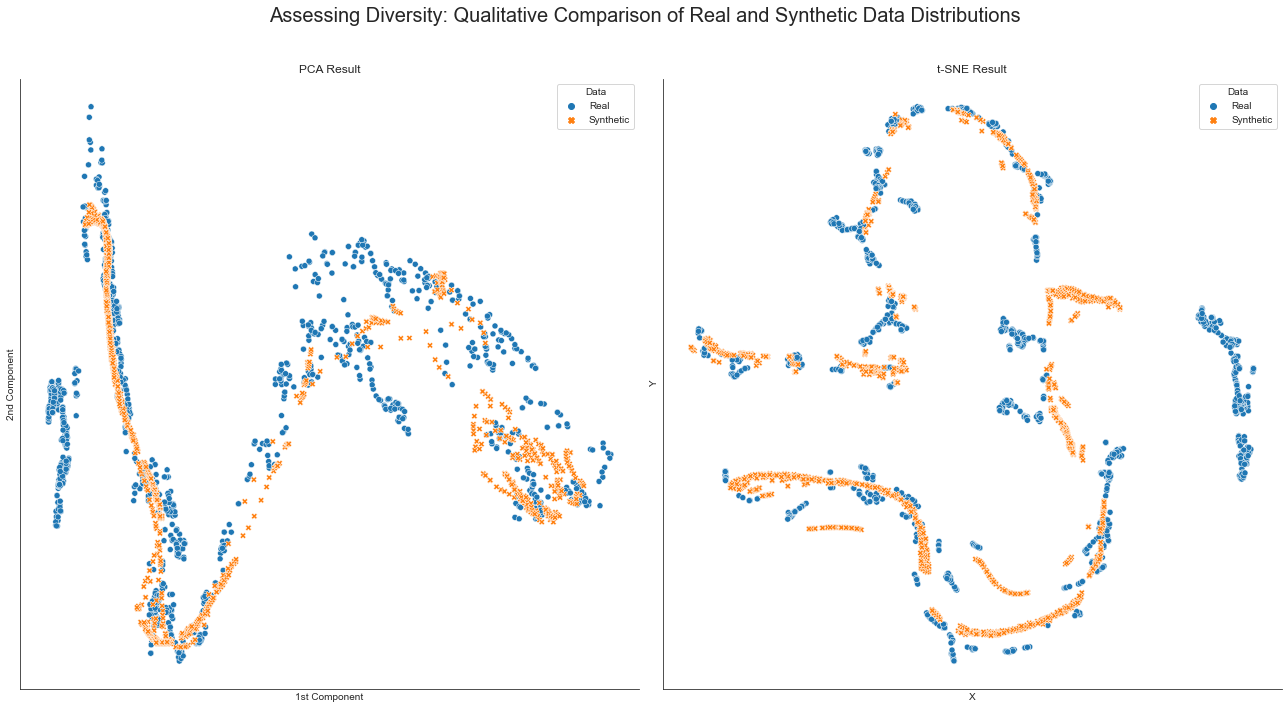

In [21]:
# Plot Result
fig, axes = plt.subplots(ncols=2, figsize=(18, 10))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result, hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')

sns.scatterplot(x='X', y='Y', data=tsne_result, hue='Data', style='Data', ax=axes[1])
sns.despine()

for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions',
             fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.88);

In [22]:
# Time Series Classification: A quantitative Assessment of "Fidelity"
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape, synthetic_data.shape

((4608, 24, 6), (4608, 24, 6))

In [65]:
real_data[:2]

array([[[4.87439448e-02, 2.20375560e-02, 0.00000000e+00, 6.93856237e-01,
         8.21105554e-02, 1.33289246e-02],
        [4.74516541e-02, 2.22460261e-02, 5.11114966e-05, 6.83225480e-01,
         8.05108954e-02, 1.08605983e-02],
        [4.68054929e-02, 2.21209476e-02, 9.51507992e-05, 6.77909854e-01,
         8.08307945e-02, 1.11426783e-02],
        [4.69777980e-02, 2.20584054e-02, 9.90832499e-05, 6.84916592e-01,
         8.17106767e-02, 1.19889953e-02],
        [4.58147799e-02, 2.18916340e-02, 4.68671440e-04, 6.79601263e-01,
         8.04709352e-02, 1.27647133e-02],
        [4.62885777e-02, 2.21626405e-02, 4.45869443e-04, 6.77426344e-01,
         7.99509914e-02, 1.17774033e-02],
        [4.59870743e-02, 2.20167125e-02, 9.98655952e-05, 6.65103874e-01,
         7.84714228e-02, 1.18479254e-02],
        [4.81839440e-02, 2.21209476e-02, 1.70644526e-04, 6.71869420e-01,
         7.88313677e-02, 1.38225711e-02],
        [4.83131848e-02, 2.10577208e-02, 5.11923216e-04, 6.60996353e-01,
       

In [66]:
synthetic_data[:2]

array([[[0.7621335 , 0.4292223 , 0.35252336, 0.24686113, 0.65802956,
         0.3435697 ],
        [0.6079562 , 0.443743  , 0.33326855, 0.18704732, 0.63318294,
         0.37264368],
        [0.6098018 , 0.43503618, 0.36090317, 0.14977837, 0.5672625 ,
         0.33281156],
        [0.5703776 , 0.441138  , 0.32779315, 0.15496358, 0.58273405,
         0.32886863],
        [0.5715625 , 0.44378173, 0.33764577, 0.16041045, 0.5879369 ,
         0.32413486],
        [0.5655956 , 0.4523372 , 0.34696245, 0.16502362, 0.58643246,
         0.3301419 ],
        [0.55993605, 0.45683002, 0.35045627, 0.16775689, 0.5841744 ,
         0.33211216],
        [0.5587042 , 0.46213776, 0.35531825, 0.16948323, 0.5821426 ,
         0.33460712],
        [0.55796576, 0.46694723, 0.35910407, 0.1705342 , 0.58020115,
         0.33721387],
        [0.5578286 , 0.47117588, 0.3622869 , 0.17106208, 0.5785119 ,
         0.33957317],
        [0.55813974, 0.47507596, 0.36518076, 0.17129652, 0.57712406,
         0.34180644],

In [25]:
n_series = real_data.shape[0]

idx = np.arange(n_series)

n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

train_data = np.vstack((real_data[train_idx], synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], synthetic_data[test_idx]))

n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train), np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test), np.zeros(n_test)))

In [27]:
# Create Simple RNN Classifier
ts_classifier = Sequential([GRU(6, input_shape=(24, 6), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')], name='Time_Series_Classifier')
ts_classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='AUC'), 'accuracy'])
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 252       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


In [28]:
result = ts_classifier.fit(x=train_data, y=train_labels, validation_data=(test_data, test_labels),
                           epochs=250, batch_size=128, verbose=0, workers=6)
ts_classifier.evaluate(x=test_data, y=test_labels)

58/58 [==============================] - 0s 3ms/step - loss: 4.8618 - AUC: 0.1636 - accuracy: 0.5141


[4.861846446990967, 0.163597971200943, 0.5140997767448425]

In [29]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [67]:
pd.concat([history.head(), history.tail()])

,loss,AUC,accuracy,val_loss,val_AUC,val_accuracy
0,0.680400,0.581312,0.534455,0.840209,0.105820,0.244577
1,0.667153,0.600010,0.543407,0.972105,0.103364,0.170282
2,0.659511,0.600024,0.542322,1.093190,0.102359,0.161063
3,0.656090,0.593224,0.549919,1.173119,0.101343,0.146963
4,0.653736,0.579408,0.555887,1.213654,0.099922,0.144794
245,0.140542,0.985619,0.951167,4.888925,0.160766,0.484816
246,0.147000,0.984825,0.946283,4.808832,0.191072,0.513557
247,0.117666,0.989610,0.962425,4.836748,0.170249,0.514100
248,0.118292,0.989517,0.961476,4.852661,0.172605,0.513557
249,0.121993,0.988979,0.958627,4.861846,0.163598,0.514100


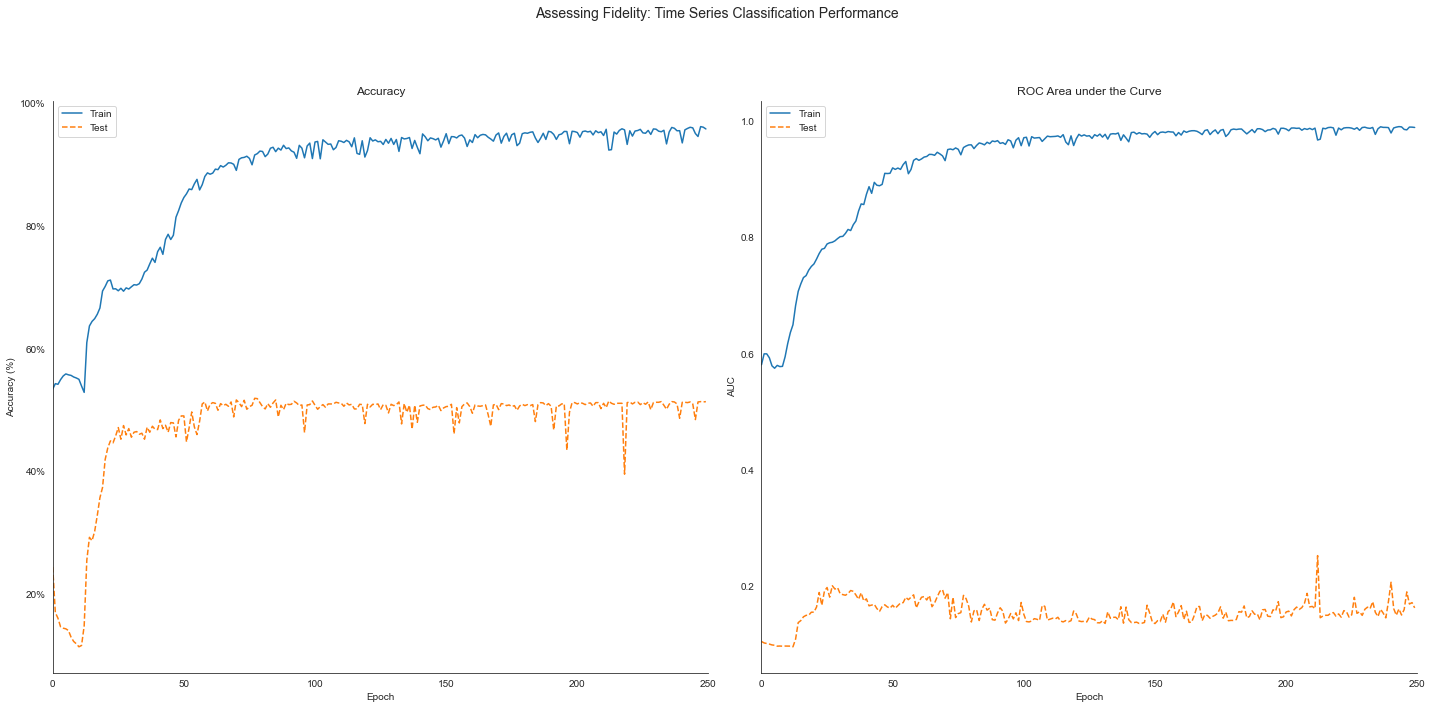

In [31]:
from matplotlib.ticker import FuncFormatter
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1],
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], title='Accuracy', style=['-', '--'], xlim=(0, 250))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

In [32]:
# Train on Synthetic, test on real: Assessing "usefulness"
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape, synthetic_data.shape

((4608, 24, 6), (4608, 24, 6))

In [33]:
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :] # as time series labeling

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3686, 23, 6), (3686, 6), (922, 23, 6), (922, 6))

In [34]:
synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]
synthetic_train.shape, synthetic_label.shape

((4608, 23, 6), (4608, 6))

In [35]:
def get_model():
    model = Sequential([GRU(12, input_shape=(seq_len-1, n_seq)), Dense(6)])
    model.compile(optimizer=Adam(), loss=MeanAbsoluteError(name='MAE'))
    return model

ts_regression = get_model()

# use the real test set to evaluate the out-of-sample performance
synthetic_result = ts_regression.fit(x=synthetic_train, y=synthetic_label,
                                     validation_data=(real_test_data, real_test_label),
                                     epochs=100, batch_size=128, verbose=0, workers=6)
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data, y=real_train_label,
                                validation_data=(real_test_data, real_test_label),
                                epochs=100, batch_size=128, verbose=0, workers=6)
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

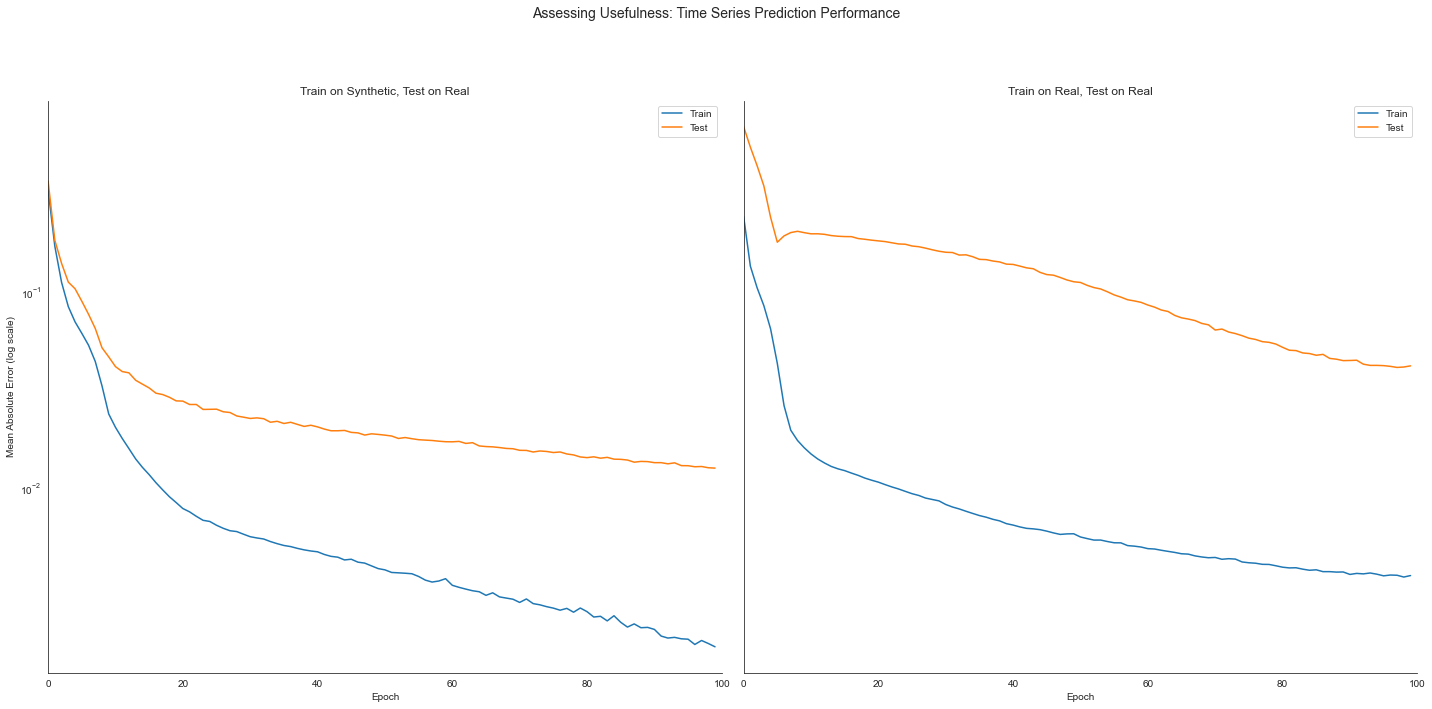

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 10), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);